# $$Sistema~de~Recomendação:Filtragem~Colaborativa$$

## $$Conceito:$$


**Filtragem Colaborativa explora a ideia de que existe relação entre os produtos e os interesses das pessoas. Muitos sistemas de recomendação usam o Collaborative Filtering para entender essas relações e dar uma precisa recomendação de um produto que o usuário pode gostar**


**Através da similaridade(distancia) dos dados(usuário ou item), a filtragem colaborativa consegue mostrar computacionalmente, por meio de um valor, o quanto dois objetos são semelhantes entre si**



**Há dois principais tipos de algoritmos de filtragem colaborativa:**

- **Filtragem colaborativa usuário-usuário(User Based):** O sistema encontra usuários parecidos com base na similaridade e recomenda produtos que os primeiros usuários parecidos escolheram no passado. O algoritmo é muito eficaz, mas requer tempo e recursos, pois necessita que todas as informações pareadas sejam computadas, o que leva tempo.


- **Filtragem colaborativa item-item(Item Based):** É semelhante ao algoritmo anterior, mas, ao invés de encontrar usuários parecidos, tenta encontrar produtos parecidos – a partir das escolhas dos usuários. Esse algoritmo consome muito menos recursos. O sistema não precisa analisar todos os índices de similaridade entre usuários, mas sim a similaridade entre produtos – o que representa um número menor de itens ao longo do tempo




__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__


__------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------__

# $$Objetivo:$$

## $$Usar~ filtragem~ Colaborativa ~para~ recomendações~ de ~livros~ através ~de ~Avaliações ~dos~ usuários$$

In [1]:
#Pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from scipy.sparse import csr_matrix

# 1° Banco de dados 

In [2]:
#Banco de dados 
dados_completo = pd.read_csv("filt-colab.csv",sep=';')

dados_completo.columns = ['Usuario','Avaliacao','Titulo']
dados_completo

,Usuario,Avaliacao,Titulo
0,276725,0,Flesh Tones: A Novel
1,2313,5,Flesh Tones: A Novel
2,6543,0,Flesh Tones: A Novel
3,8680,5,Flesh Tones: A Novel
4,10314,9,Flesh Tones: A Novel
...,...,...,...
196837,276680,0,Home Crafts (Historic Communities (Paperback))
196838,276680,0,"The Old Sturbridge Village Cookbook, 2nd : Aut..."
196839,276680,0,City of Masks : A Cree Black Novel
196840,276681,10,Chorus


**Banco de dados trás as colunas: Usuario, Avaliacão e Titulo dos livros**

## Análise Exploratória dos Dados

In [3]:
# Resumo dos dados
print("Resumo dos Dados")
print("-"*50)
print("Número Total de Livro:", len(np.unique(dados_completo.Titulo)))
print("Número Total de Usuários:", len(np.unique(dados_completo.Usuario)))
print("Número Total de Avaliações:", dados_completo.shape[0])

Resumo dos Dados
--------------------------------------------------
Número Total de Livro: 68717
Número Total de Usuários: 38511
Número Total de Avaliações: 196842


In [4]:
# Verificando a média das avaliações
dados_completo.describe()['Avaliacao']

count    196842.000000
mean          3.117907
std           3.925304
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: Avaliacao, dtype: float64

**Observe que as avaliações vão de 0 à 10, com média = 3.11**

In [5]:
#Verificar Valores nulos
null_Usuario = sum(dados_completo.Usuario.isna())
null_Avaliacao = sum(dados_completo.Avaliacao.isna())
null_Titulo = sum(dados_completo.Titulo.isna())

print(f'Total de dados nulos: {null_Usuario + null_Avaliacao + null_Titulo}')

Total de dados nulos: 0


**Nenhum dado nulo esta presente no dataframe**

In [6]:
# Verificando se temos valores duplicados 
dados_completo.duplicated().sum()

173

In [7]:
#Eliminar os registros duplicados
dados_completo = dados_completo.drop_duplicates()
dados_completo.duplicated().sum()

0

**Eliminamos os dados duplicados do dataset**

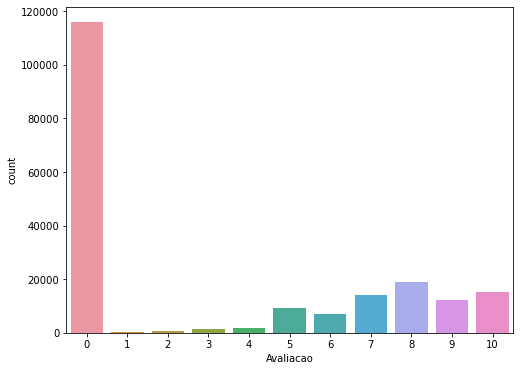

In [8]:
#Plot da coluna Avaliacao
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(dados_completo.Avaliacao);

In [9]:
#Porcentagem de avaliações com 0
zero = len(dados_completo[dados_completo.Avaliacao==0])
total = zero/len(dados_completo)
round(total*100,1)

59.0

**Veja que a distribuição está desequilibrada, com 59% das avaliações com nota 0**

**OBS: Para o sistema de recomendação os dados não precisa estar balanceados**

## Filtrar somente os Livros com mais de 20 avaliações

In [10]:
#Verificar a quantidade de vezes que os livros foram avaliados

rating_qts = dados_completo.groupby(by = 'Titulo')['Usuario'].count().reset_index()
rating_qts.columns = ['Titulo','Usuario']

rating_qts.sort_values(by='Usuario',ascending=False)

mini = rating_qts.Usuario.min()
maxi = rating_qts.Usuario.max()
mean = rating_qts.Usuario.mean()

print(f'Minimo de avaliações de um livro: {mini}')
print(f'\nMaximo de avaliações de um livro: {maxi}')
print(f'\nMédia de avaliações de um livro: {round(mean,1)}')

Minimo de avaliações de um livro: 1

Maximo de avaliações de um livro: 820

Média de avaliações de um livro: 2.9


**Note que a maioria dos livros tem menos de 3 avaliações, vamos selecionar os livros que tiveram mais de 20 avaliações para conseguir um modelo mais adequado**

In [11]:
#Exluindo os livros que tiveram menos de 20 avaliações 

#Extrair os indices dos usuarios que avaliaram mais de 200 livros 
livr_20 = dados_completo.Titulo.value_counts() >20
livr_20 = livr_20[livr_20].index



In [12]:
# Filtrar na tabela os usuarios que avaliaram menos de 200 livros

tabela_final1 = dados_completo[dados_completo['Titulo'].isin(livr_20)]


# Número de avaliações por usuário
num_aval_por_user2 = tabela_final1.groupby(by = 'Titulo')['Usuario'].count().sort_values(ascending = False)

maxi = num_aval_por_user2.max()
mini = num_aval_por_user2.min()
mean = num_aval_por_user2.mean()

print(f'Minimo de avaliações de um livro: {mini}')
print(f'\nMaximo de avaliações de um livro: {maxi}')
print(f'\nMédia de avaliações de um livro: {round(mean,1)}')


Minimo de avaliações de um livro: 21

Maximo de avaliações de um livro: 820

Média de avaliações de um livro: 51.7


**Agora todos os livros tiveram mais de 20 avaliações, e a média subiu para 51 avaliações por livro**

## Filtrar somente os usuários com mais de 10 avaliações e menos de 200 avaliações

In [13]:
# Número de avaliações por usuário
num_aval_por_user = tabela_final1.groupby(by = 'Usuario')['Avaliacao'].count().sort_values(ascending = False)

#Filtrando numeros de avaliações > 200
aval200 = num_aval_por_user[num_aval_por_user>200]

#Filtrando numeros de avaliações <= 10
aval1 = num_aval_por_user[num_aval_por_user<=10]

print(f'Numero de avaliações maior que 200: {len(aval200)}')
print(f'\nNumero de avaliações menor que 10: {len(aval1)}')

Numero de avaliações maior que 200: 1

Numero de avaliações menor que 10: 16594


**Filtramos as avaliações maiores do que 200, pois o site pode ter robôs que ficam avaliando os livros, já usuários que avaliaram até 10 livros não são interessantes para o modelo, pois são usuários aleatórios que não tem engajamento com o site**

**OBS: As escolhas dos valores foram arbitrárias, apenas para fins didáticos, porém com coerência na analise**

In [14]:
#Exluindo as avaliações menor que 2 e maiores que 200

#Extrair os indices dos usuarios que avaliaram mais de 200 livros 
aval_200 = tabela_final1.Usuario.value_counts() < 200
aval_200 = aval_200[aval_200].index

#Extrair os indices dos usuarios que avaliaram menos de 2 livros 
aval_1 = tabela_final1.Usuario.value_counts() > 10
aval_1 = aval_1[aval_1].index
aval_1

Int64Index([ 11676, 153662,  35859,  76352,  16795, 175003,  60244,  73394,
            198711,  78783,
            ...
            122716, 205473, 196985, 191187,  34588, 143163, 153723, 173481,
            178181,  34300],
           dtype='int64', length=790)

**Índices dos usuários filtrados**

In [15]:
# Filtrar na tabela os usuarios que avaliaram menos de 200 livros

tabela_final2 = tabela_final1[tabela_final1['Usuario'].isin(aval_200)]

# Filtrar na tabela os usuarios que avaliaram mais de 10 livros
tabela_final2 = tabela_final2[tabela_final2['Usuario'].isin(aval_1)]

# Número de avaliações por usuário
num_aval_por_user2 = tabela_final2.groupby(by = 'Usuario')['Avaliacao'].count().sort_values(ascending = False)

maxi = num_aval_por_user2.max()
mini = num_aval_por_user2.min()

print(f'Numero maximo de avaliações feitas pelo Usuário: {maxi}')
print(f'\nNumero minimo de avaliações feitas pelo Usuário: {mini}')
print(f'\nTotal de Usuarios: {len(np.unique(tabela_final1.Usuario))}')


Numero maximo de avaliações feitas pelo Usuário: 199

Numero minimo de avaliações feitas pelo Usuário: 11

Total de Usuarios: 17384


**Agora o dataset só tem usuários com perfis equilibrado de avaliações**

**OBS: Novamente a escolha dos valores foram arbitrarias, apenas para fins didáticos, porém com coerência na analise**

# Filtro Colaborativo baseado em Usuário

## Calcular a similaridade dos Usuários:

- Para calcular a similaridade dos usuários 1° precisamos criar uma matriz esparsa




## Matriz Esparsas

- A Matriz esparsa cria valores 0 quando não há relação entre as linhas e as colunas, neste caso seria quando não houvesse avaliação feita pelo usuário, caso contrário o dado é o valor da avaliação


- Como o Matriz Esparsa cria valores 0, precisamos substituir as avaliações feitas pelo usuário com o valor 0 para 1


- Com esses dados a Matriz Esparsa vai criar uma matriz ortogonal com os **títulos** em colunas, os **usuários** em linhas e as **avaliações** feitas pelos usuários como sendo os dados da matriz


In [16]:
## Alterar valor 0 da coluna Avaliacao

tabela_final2.loc[(tabela_final2['Avaliacao'])==0,'Avaliacao']=1

mini = tabela_final2.Avaliacao.min()

print(f'Valor minimo de uma avaliação: {mini}')

Valor minimo de uma avaliação: 1


**Agora com o valor mínimo da avaliação sendo 1, podemos criar a matriz esparsa**

## Criar Matriz Esparsa

- **OBS: Para criar a Matriz Esparsa precisamos que todos os dados sejam numéricos, portanto, precisaríamos transformar a coluna título que é um dado categórico em um dado numérico, e para não precisar fazer essa transformação, 1° criamos uma matriz densa com valores NaN onde não houver relações entre colunas e linhas e depois transformamos esses dados nulos em 0, por fim convertemos a matriz densa em uma matriz esparsa**

## Matriz Densa 

In [17]:
#Criar a matriz Densa 
Matriz_densa_user = tabela_final2.pivot_table(columns='Titulo',index='Usuario',values='Avaliacao')
Matriz_densa_user

Titulo,09/nov,16 Lighthouse Road,1984,"20,000 Leagues Under the Sea (Wordsworth Collection)",204 Rosewood Lane,311 Pelican Court,7b,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 4th Course of Chicken Soup for the Soul: 101 More Stories to Open the Heart and Rekindle the Spirit,...,With A Southern Touch,With Malice,Without A Trace,"Wolves of the Calla (The Dark Tower, Book 5)",Worst Fears,Wuthering Heights (Wordsworth Classics),"YESTERDAY, I CRIED : Celebrating the Lessons of Living and Loving",Year of Wonders: A Novel of the Plague,You Shall Know Our Velocity,Zen Attitude
Usuario,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2891,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275970,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN


**Note que onde não a relação entre as linhas e colunas foram gerados dados NaN, vamos substituir os dados por 0**

In [18]:
# Substituir NaN pelo numero 0 
Matriz_densa_user.fillna(0,inplace=True)
Matriz_densa_user

Titulo,09/nov,16 Lighthouse Road,1984,"20,000 Leagues Under the Sea (Wordsworth Collection)",204 Rosewood Lane,311 Pelican Court,7b,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 4th Course of Chicken Soup for the Soul: 101 More Stories to Open the Heart and Rekindle the Spirit,...,With A Southern Touch,With Malice,Without A Trace,"Wolves of the Calla (The Dark Tower, Book 5)",Worst Fears,Wuthering Heights (Wordsworth Classics),"YESTERDAY, I CRIED : Celebrating the Lessons of Living and Loving",Year of Wonders: A Novel of the Plague,You Shall Know Our Velocity,Zen Attitude
Usuario,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2891,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275970,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


**Substituimos os valores NaN por 0 , agora podemos transformar a Matriz Densa em Esparsa**

**Porém antes:**

## Excluir usuários que não deram nenhuma nota acima de 7

- Se o usuário não avaliou com notas acima de 7 nenhum produto, não conhecemos o seu gosto, portanto, a filtragem colaborativa pode não ser o método ideal para esse tipo de usuário no começo

In [19]:
#Verificar a nota maxima de cada usuário
Matriz_densa_user['Max'] = Matriz_densa_user.max(axis=1)
Matriz_densa_user[Matriz_densa_user.Max>7]

#selecionar apenas os usuário que deram pelo menos 7 em uma das avaliações
Matriz_densa_user = Matriz_densa_user[Matriz_densa_user.Max>=8]
Matriz_densa_user= Matriz_densa_user.iloc[:,:958]#Excluindo a variável Max
Matriz_densa_user

Titulo,09/nov,16 Lighthouse Road,1984,"20,000 Leagues Under the Sea (Wordsworth Collection)",204 Rosewood Lane,311 Pelican Court,7b,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A 4th Course of Chicken Soup for the Soul: 101 More Stories to Open the Heart and Rekindle the Spirit,...,With A Southern Touch,With Malice,Without A Trace,"Wolves of the Calla (The Dark Tower, Book 5)",Worst Fears,Wuthering Heights (Wordsworth Classics),"YESTERDAY, I CRIED : Celebrating the Lessons of Living and Loving",Year of Wonders: A Novel of the Plague,You Shall Know Our Velocity,Zen Attitude
Usuario,,,,,,,,,,,,,,,,,,,,,
2891,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274061,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Agora todos os usuários podem dar sugestões de livros, pois deram pelo menos uma nota 8, que é o limite para considerar uma avaliação boa**

# Transformar Matriz Densa em Matriz Esparsa

- Na tabela de matriz densa tem muitos valores zeros, e para criar o modelo esses valores zeros aumenta o poder computacional, portanto, transformamos a matriz densa em uma matriz esparsa para oculta os valores zeros durante a modelagem

In [20]:
#Transformação
from scipy.sparse import csr_matrix
Matriz_esparsa_user = csr_matrix(Matriz_densa_user)
Matriz_esparsa_user

<675x958 sparse matrix of type '<class 'numpy.float64'>'
	with 17926 stored elements in Compressed Sparse Row format>

In [21]:
# Calculamos a esparsidade da matriz
linhas, colunas = Matriz_esparsa_user.shape
elementos_nao_zero = Matriz_esparsa_user.count_nonzero()
print("Esparsidade da Matriz: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da Matriz: 97.2278666975953 % 


**97% da matriz contém o valor 0, que neste contexto significa que muitos usuários não avaliaram muitos Livro, o que é normal, pois se muitos usuários tivessem avaliados muitos Livro não seria necessária uma matriz esparsa**

# Modelagem:

## Algoritimo NearestNeighbors, Metrica: Euclidiana

- No modelo 1 usaremos a distância euclidiana para calcular a similaridade dos usuários

In [22]:
#Modelo NearestNeighbors
from sklearn.neighbors import NearestNeighbors
modelo1 = NearestNeighbors(algorithm='brute',n_neighbors=3,metric='euclidean')
modelo1.fit(Matriz_esparsa_user)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=3)

In [23]:
#Sugestão de livros para o usuário 274808
usuario = 274808
distancia , sugestao =  modelo1.kneighbors(Matriz_densa_user.loc[usuario].values.reshape(1,-1))

vizinho_1 = Matriz_densa_user.iloc[sugestao.flatten()[1]].to_frame().columns[0]

vizinho_2 = Matriz_densa_user.iloc[sugestao.flatten()[2]].to_frame().columns[0]

#Loop
for i in range(0 , len(sugestao.flatten())):
    if i == 0:
        print(f'Para o Usuário: {usuario}')
    else:
        print(f'\n{i}° Usuario mais Similiar = {Matriz_densa_user.iloc[sugestao.flatten()[i]].to_frame().columns[0]}, Distância: {distancia.flatten()[i]}')

Para o Usuário: 274808

1° Usuario mais Similiar = 265313, Distância: 10.677078252031311

2° Usuario mais Similiar = 196466, Distância: 12.12435565298214


**Usuários considerados mais similares para o usuário 274808**

In [24]:
#Filtra os livros que o usuario 274808 avaliou
filt_274808_nota = Matriz_densa_user.loc[usuario].to_frame()>0
index_274808 = filt_274808_nota[filt_274808_nota.iloc[:,0]==1].index

#Filtrar as notas do usuario 274808
filt_index_274808 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_274808)]
usuario_notas = filt_index_274808[usuario].to_frame()
usuario_notas

,274808
Titulo,
A Painted House,1.0
A Wind in the Door (Laurel Leaf Books),8.0
Chicken Soup for the Teenage Soul (Chicken Soup for the Soul),1.0
Chicken Soup for the Teenage Soul II (Chicken Soup for the Soul Series),1.0
"Chicken Soup for the Teenage Soul III : More Stories of Life, Love and Learning (Chicken Soup for the Soul)",1.0
Girl in Hyacinth Blue,1.0
"Monster Blood (Goosebumps, No 3)",1.0
The Kitchen God's Wife,1.0
Thursday'S At Eight,1.0


**Através das sugestões feitas, vamos comparar as notas entre os usuários que foram indicados e verificar a coerência do algoritimo com essas indicações**

**Esse é o passo mais importante para verificar como o algoritimo realizou as sugestões, pois através desse usuário que vamos conseguir verificar a similaridade com os outros usuários**

**OBS: Observe que o usuário avaliou somente 1 livro como sendo satisfatório (nota acima de 7), portanto o algoritimo terá dificuldade para encontrar usuários semelhantes para recomendações**


In [25]:
#Filtra os livros que o vizinho_1 avaliou
filt_715_nota = Matriz_densa_user.loc[vizinho_1].to_frame()>0
index_715 = filt_715_nota[filt_715_nota.iloc[:,0]==1].index



#Filtrar as notas 
filt_index_715 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_715)]
filt_index_715 = filt_index_715[vizinho_1].to_frame()
vizinho_1_notas = filt_index_715
vizinho_1_notas

,265313
Titulo,
A Painted House,1.0
A Wind in the Door (Laurel Leaf Books),9.0
Abduction,1.0
Acts of War (Tom Clancy's Op Center (Paperback)),1.0
All I Really Need to Know,1.0
Certain Prey,1.0
Chicken Soup for the Soul (Chicken Soup for the Soul),1.0
Dreamcatcher,1.0
Easy Prey,1.0


**Todos os livros que o vizinho_1 avaliou**

In [26]:
#Filtra os livros que o vizinho_2 deu nota
filt_715_nota = Matriz_densa_user.loc[vizinho_2].to_frame()>0
index_715 = filt_715_nota[filt_715_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_index_715 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_715)]
filt_index_715 = filt_index_715[vizinho_2].to_frame()
vizinho_2_notas = filt_index_715
vizinho_2_notas

,196466
Titulo,
A Fine Balance,1.0
A Painted House,1.0
Bag of Bones,1.0
"Breath, Eyes, Memory",1.0
Daughter of Fortune: A Novel,1.0
Miracle at St. Anna,1.0
Running with Scissors: A Memoir,1.0
Skyward,1.0
The Final Judgment,1.0


**Todos os livros que o vizinho_2 avaliou**

In [27]:
#Filtrar os livros em comuns dos usuários
ind = usuario_notas.index
usuario_notas[usuario_notas.index.isin(ind)]
join1 = usuario_notas.join(vizinho_1_notas)
join1.join(vizinho_2_notas)

,274808,265313,196466
Titulo,,,
A Painted House,1.0,1.0,1.0
A Wind in the Door (Laurel Leaf Books),8.0,9.0,NaN
Chicken Soup for the Teenage Soul (Chicken Soup for the Soul),1.0,NaN,NaN
Chicken Soup for the Teenage Soul II (Chicken Soup for the Soul Series),1.0,NaN,NaN
"Chicken Soup for the Teenage Soul III : More Stories of Life, Love and Learning (Chicken Soup for the Soul)",1.0,NaN,NaN
Girl in Hyacinth Blue,1.0,NaN,NaN
"Monster Blood (Goosebumps, No 3)",1.0,NaN,NaN
The Kitchen God's Wife,1.0,NaN,NaN
Thursday'S At Eight,1.0,NaN,NaN


**Neste modelo há um problema com a similaridade, pois o usuário 274808 só tem uma nota baixa em comum com o usuário 196466, não sendo o usuário ideal para gerar recomendações, já o usuário 265313 pode ser considerado similar ao usuário 274808 pois tem avaliações alta e baixa em comum**

# Conclusão 1:

**Não precisamos seguir em frente na análise com esses dados, pois conseguimos perceber que a maioria das avaliações são de notas baixas, portanto o algoritimo está considerando a distância das notas baixas para dar recomendações de livros. Se 2 pessoas leram alguns livros semelhantes e deram notas baixas, o algoritimo está indicando livros que também tiveram nota baixa para esses usuários**

# Conclusão 2

**Podemos afirmar que os usuários que deram nota alta para um livro, podem ter similaridade entre eles, também podemos afirmar que os usuários que deram nota baixa e alta para livros iguais, também podem ter similaridade, agora não podemos afirmar que quem deu nota baixa para um livro, pode ter similaridade com outro usuário**

**Com a conclusão acima podemos perceber que não adianta apenas filtrar as notas altas dos usuários, pois iria excluir muitos livros que também poderia ter similaridade com outro usuário através das notas altas e baixas**

## Algoritimo NearestNeighbors, Metrica: Cosseno

- Vamos usar o mesmo usuário para gerar recomendações, porém agora com a similaridade de Cosseno

In [28]:
#Modelo NearestNeighbors
from sklearn.neighbors import NearestNeighbors
modelo2 = NearestNeighbors(algorithm='brute',n_neighbors=3,metric='cosine')
modelo2.fit(Matriz_esparsa_user)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [29]:
#Sugestão de livros para o usuário 274808
usuario = 274808
distancia , sugestao =  modelo2.kneighbors(Matriz_densa_user.loc[usuario].values.reshape(1,-1))

vizinho_1 = Matriz_densa_user.iloc[sugestao.flatten()[1]].to_frame().columns[0]

vizinho_2 = Matriz_densa_user.iloc[sugestao.flatten()[2]].to_frame().columns[0]

#Loop
for i in range(0 , len(sugestao.flatten())):
    if i == 0:
        print(f'Para o Usuário: {usuario}')
    else:
        print(f'\n{i}° Usuario mais Similiar = {Matriz_densa_user.iloc[sugestao.flatten()[i]].to_frame().columns[0]}, Distância: {distancia.flatten()[i]}')

Para o Usuário: 274808

1° Usuario mais Similiar = 265313, Distância: 0.3777705989813659

2° Usuario mais Similiar = 88733, Distância: 0.6601922979863772


**Note que o usuário 265313 também foi indicado como sugestão no modelo 1**

In [30]:
#Filtra os livros que o usuario 274808 avaliou
filt_274808_nota = Matriz_densa_user.loc[usuario].to_frame()>0
index_274808 = filt_274808_nota[filt_274808_nota.iloc[:,0]==1].index

#Filtrar as notas do usuario 274808
filt_index_274808 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_274808)]
usuario_notas = filt_index_274808[usuario].to_frame()
usuario_notas

,274808
Titulo,
A Painted House,1.0
A Wind in the Door (Laurel Leaf Books),8.0
Chicken Soup for the Teenage Soul (Chicken Soup for the Soul),1.0
Chicken Soup for the Teenage Soul II (Chicken Soup for the Soul Series),1.0
"Chicken Soup for the Teenage Soul III : More Stories of Life, Love and Learning (Chicken Soup for the Soul)",1.0
Girl in Hyacinth Blue,1.0
"Monster Blood (Goosebumps, No 3)",1.0
The Kitchen God's Wife,1.0
Thursday'S At Eight,1.0


**Todos os livros que o Usuário 274808 avaliou**

In [31]:
#Filtra os livros que o vizinho_1 avaliou
filt_1_nota = Matriz_densa_user.loc[vizinho_1].to_frame()>0
index_1 = filt_1_nota[filt_1_nota.iloc[:,0]==1].index



#Filtrar as notas 
filt_index_1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_1)]
filt_index_1 = filt_index_1[vizinho_1].to_frame()
vizinho_1_notas = filt_index_1
vizinho_1_notas

,265313
Titulo,
A Painted House,1.0
A Wind in the Door (Laurel Leaf Books),9.0
Abduction,1.0
Acts of War (Tom Clancy's Op Center (Paperback)),1.0
All I Really Need to Know,1.0
Certain Prey,1.0
Chicken Soup for the Soul (Chicken Soup for the Soul),1.0
Dreamcatcher,1.0
Easy Prey,1.0


**Todos os livros que o vizinho_1 avaliou**

In [32]:
#Filtra os livros que o vizinho_2 deu nota
filt_2_nota = Matriz_densa_user.loc[vizinho_2].to_frame()>0
index_2 = filt_2_nota[filt_2_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_index_1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_2)]
filt_index_1 = filt_index_1[vizinho_2].to_frame()
vizinho_2_notas = filt_index_1
vizinho_2_notas

,88733
Titulo,
"A Cup of Comfort: Stories That Warm Your Heart, Lift Your Spirit, and Enrich Your Life",1.0
A Gift To Last,1.0
A Tree Grows in Brooklyn,1.0
A Wind in the Door (Laurel Leaf Books),10.0
Angela's Ashes: A Memoir,1.0
At Home in Mitford (The Mitford Years),1.0
"Book Lust: Recommended Reading for Every Mood, Moment, and Reason",1.0
Breach of Duty: A J.P. Beaumont Mystery,1.0
"Chicken Soup for the Cat and Dog Lover's Soul - Celebrating Pets as Family with Stories About Cats, Dogs and Other Critters",1.0


**Todos os livros que o vizinho_2 avaliou**

In [33]:
#Filtrar os livros em comuns e verificar as notas dos usuários
ind = usuario_notas.index
usuario_notas[usuario_notas.index.isin(ind)]
join1 = usuario_notas.join(vizinho_1_notas)
similari = join1.join(vizinho_2_notas)
similari

,274808,265313,88733
Titulo,,,
A Painted House,1.0,1.0,NaN
A Wind in the Door (Laurel Leaf Books),8.0,9.0,10.0
Chicken Soup for the Teenage Soul (Chicken Soup for the Soul),1.0,NaN,NaN
Chicken Soup for the Teenage Soul II (Chicken Soup for the Soul Series),1.0,NaN,NaN
"Chicken Soup for the Teenage Soul III : More Stories of Life, Love and Learning (Chicken Soup for the Soul)",1.0,NaN,NaN
Girl in Hyacinth Blue,1.0,NaN,NaN
"Monster Blood (Goosebumps, No 3)",1.0,NaN,NaN
The Kitchen God's Wife,1.0,NaN,NaN
Thursday'S At Eight,1.0,NaN,NaN


**Note que agora com a similaridade de cosseno o modelo ficou mais coerente, pois os 2 usuários que foram indicados possui similaridade com o usuário 274808, ou através das notas baixas e altas ou somente de notas altas, e não mais apenas com notas baixas como era no modelo 1**

**Com a similaridade de cosseno sendo coerente com esses dados, podemos fazer um loop para encontrar os usuário com as menores distancias**

In [34]:
#Fazer um loop e encontrar as menores distancias entre 2 usuários

usuario1 = range(0 , len(Matriz_densa_user))
k = []
s = []
for i in usuario1:
    distancia , sugestao =  modelo2.kneighbors(Matriz_densa_user.iloc[i].values.reshape(1,-1))
    k.append(distancia)
    s.append(sugestao)


In [35]:
#Converter as sugestões para dataframe
r = []
l = 0
for i in range(0 , len(Matriz_densa_user)):
    r.append(s[l].flatten()[0:3])
    l+=1
sugest = pd.DataFrame(r,columns=['Indice_Usuario','Indice_Vizinho_1','Indice_Vizinho_2'])

#Converter as distâncias para dataframe
e = []
l = 0
for i in range(0 , len(Matriz_densa_user)):
    e.append(k[l].flatten()[0:3])
    l+=1
dist = pd.DataFrame(e,columns=['D','Distancia_1','Distancia_2'])
dist = dist.iloc[:,1:]

#Unir os 2 dataframes
sugestao = sugest.join(dist)
sugestao

,Indice_Usuario,Indice_Vizinho_1,Indice_Vizinho_2,Distancia_1,Distancia_2
0,0,434,544,0.577331,0.636266
1,1,224,403,0.608092,0.739849
2,2,3,447,0.542710,0.698988
3,3,2,550,0.542710,0.711424
4,4,70,431,0.710310,0.715615
...,...,...,...,...,...
670,670,246,312,0.635645,0.720957
671,671,43,322,0.657619,0.673906
672,672,646,217,0.377771,0.660192
673,673,309,619,0.676532,0.684610


In [36]:
#Verificar as menores distâncias
sugestao.sort_values('Distancia_1')

,Indice_Usuario,Indice_Vizinho_1,Indice_Vizinho_2,Distancia_1,Distancia_2
430,430,151,143,0.152299,0.505127
151,151,430,143,0.152299,0.494175
570,570,382,318,0.176780,0.321754
382,382,570,318,0.176780,0.292266
454,454,495,375,0.249598,0.469278
...,...,...,...,...,...
201,201,138,124,0.796568,0.805392
630,630,97,582,0.818581,0.819592
295,295,251,532,0.831512,0.840510
471,471,287,567,0.836475,0.862957


**Veja que os numeros das colunas dos usuários estão indicando o índice, precisamos converter o índice para encontrar os usuários**

In [37]:
#Sugestão de livros para o usuário de index 430
index = 430
distancia , sugestao =  modelo2.kneighbors(Matriz_densa_user.iloc[index].values.reshape(1,-1))

usuario = Matriz_densa_user.iloc[sugestao.flatten()[0]].to_frame().columns[0]

vizinho_1 = Matriz_densa_user.iloc[sugestao.flatten()[1]].to_frame().columns[0]

vizinho_2 = Matriz_densa_user.iloc[sugestao.flatten()[2]].to_frame().columns[0]

#Loop
for i in range(0 , len(sugestao.flatten())):
    if i == 0:
        print(f'Para o Usuário: {usuario}')
    else:
        print(f'\n{i}° Usuario mais Similiar = {Matriz_densa_user.iloc[sugestao.flatten()[i]].to_frame().columns[0]}, Distância: {distancia.flatten()[i]}')

Para o Usuário: 179744

1° Usuario mais Similiar = 62881, Distância: 0.15229929147837218

2° Usuario mais Similiar = 59150, Distância: 0.5051271454924519


**Note que convertemos o índice da tabela no número do usuário**

In [38]:
#Filtra os livros que o usuario 274808 avaliou
filt_274808_nota = Matriz_densa_user.loc[usuario].to_frame()>0
index_274808 = filt_274808_nota[filt_274808_nota.iloc[:,0]==1].index

#Filtrar as notas do usuario 274808
filt_index_274808 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_274808)]
usuario_notas = filt_index_274808[usuario].to_frame()

#Filtra os livros que o vizinho_1 avaliou
filt_1_nota = Matriz_densa_user.loc[vizinho_1].to_frame()>0
index_1 = filt_1_nota[filt_1_nota.iloc[:,0]==1].index



#Filtrar as notas 
filt_index_1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_1)]
filt_index_1 = filt_index_1[vizinho_1].to_frame()
vizinho_1_notas = filt_index_1

#Filtra os livros que o vizinho_2 deu nota
filt_2_nota = Matriz_densa_user.loc[vizinho_2].to_frame()>0
index_2 = filt_2_nota[filt_2_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_index_1 = Matriz_densa_user.T[Matriz_densa_user.T.index.isin(index_2)]
filt_index_1 = filt_index_1[vizinho_2].to_frame()
vizinho_2_notas = filt_index_1


#Filtrar os livros em comuns dos usuários
ind = usuario_notas.index
usuario_notas[usuario_notas.index.isin(ind)]
join1 = usuario_notas.join(vizinho_1_notas)
similari2 = join1.join(vizinho_2_notas)
similari2


,179744,62881,59150
Titulo,,,
Alive : The Story of the Andes Survivors (Avon Nonfiction),1.0,NaN,NaN
All I Really Need to Know,1.0,NaN,1.0
Call of the Wild,1.0,NaN,NaN
EVERYTHING SHE EVER WANTED,1.0,NaN,NaN
"Faith of the Fallen (Sword of Truth, Book 6)",1.0,NaN,NaN
Hannibal,1.0,NaN,NaN
Leaving Home/a Collection of Lake Wobegon Stories,1.0,NaN,NaN
One Hundred Years of Solitude,1.0,NaN,NaN
Stolen Blessings,1.0,NaN,NaN


**Observe que novamente temos poucas avaliações em comum entre os usuário, porém o modelo é coerente**

In [39]:
#Sugestões Vizinho_1
vizinho_1_notas[vizinho_1_notas[62881]>7]


,62881
Titulo,
The Outsiders (Now in Speak!),8.0


**Observe que a nota do vizinho_1 acima de 7 foi o filme já assistido pelo usuário 179744, portanto ele não tem nenhum filme para recomendar**

In [40]:
#Sugestões Vizinho_2
vizinho_2_notas[vizinho_2_notas[59150]>7]

,59150
Titulo,
"Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies",8.0
The Outsiders (Now in Speak!),8.0
The Rainmaker,8.0


**Vizinho_2 possui 2 filmes com notas acima de 7 que o usuário 179744 ainda não assistiu, portanto esses livros seriam uma boa indicação**

# Conclusão_Filtragem_Colaborativa_Usuário: 

**O sistema de recomendação de filtragem colaborativa de usuário é uma excelente forma de indicação de produtos, porém temos que tomar cuidado com o algoritimo e as metricas a serem usadas, observamos com esses modelos que independente da distância usada não dá para confiar 100% no algoritimo, pois ele pode estar usando somente avaliações com notas baixas como similaridade entre usuários, e mesmo havendo notas altas entre produtos similares o usuário pode não ter nenhuma sugestão com outras avaliações altas e somente com avaliações baixas**

# Filtro Colaborativo baseado em Itens

- Precisamos criar uma matriz esparsa com a linhas sendo os itens

In [41]:
#Criar a matriz Densa 
Matriz_densa_item = tabela_final2.pivot_table(columns='Usuario',index='Titulo',values='Avaliacao')

# Substituir NaN pelo numero 0 
Matriz_densa_item.fillna(0,inplace=True)

## Excluir usuários que não deram nenhuma nota acima de 7

#Verificar a nota maxima de cada usuário
Matriz_densa_item['Max'] = Matriz_densa_item.max(axis=1)
Matriz_densa_item[Matriz_densa_item.Max>7]

#selecionar apenas os usuário que deram pelo menos 7 em uma das avaliações
Matriz_densa_item = Matriz_densa_item[Matriz_densa_item.Max>=8]
Matriz_densa_item= Matriz_densa_item.iloc[:,:958]#Excluindo a variável Max
Matriz_densa_item

Usuario,254,2891,3363,4017,6242,6251,6543,6563,6575,7125,...,273906,273979,274004,274061,274308,274808,275970,277427,278418,Max
Titulo,,,,,,,,,,,,,,,,,,,,,
09/nov,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
204 Rosewood Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
311 Pelican Court,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wuthering Heights (Wordsworth Classics),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
"YESTERDAY, I CRIED : Celebrating the Lessons of Living and Loving",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
Year of Wonders: A Novel of the Plague,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0


**Fizemos os mesmos tratamentos de dados como na filtragem colaborativa por usuário antes de transformar a matriz densa em esparsa**

# Transformar Matriz Densa em Matriz Esparsa

In [42]:
#Transformação

Matriz_esparsa_item = csr_matrix(Matriz_densa_item)
Matriz_esparsa_item

<817x790 sparse matrix of type '<class 'numpy.float64'>'
	with 19892 stored elements in Compressed Sparse Row format>

In [43]:
# Calculamos a esparsidade da matriz
linhas, colunas = Matriz_esparsa_item.shape
elementos_nao_zero = Matriz_esparsa_item.count_nonzero()
print("Esparsidade da Matriz: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da Matriz: 96.91802364315262 % 


**96% da matriz contém o valor 0**

# Modelagem:

## Algoritimo NearestNeighbors, Metrica: Cosseno

In [44]:
#Modelo NearestNeighbors
from sklearn.neighbors import NearestNeighbors
modelo3 = NearestNeighbors(algorithm='brute',n_neighbors=3,metric='cosine')
modelo3.fit(Matriz_esparsa_item)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [45]:
#Sugestão de livros para quem leu Harry Potter and the Order of the Phoenix (Book 5)
distancia , sugestao =  modelo3.kneighbors(Matriz_densa_item
                                          [Matriz_densa_item.index.str.contains
                                           ("Harry Potter and the Order of the Phoenix")].values.reshape(1,-1))
sugestao

array([[311, 313,  32]], dtype=int64)

**Note que novamente o modelo traz os índices, precisamos converter para os nomes dos livros**

In [46]:
#Convertendo os indices em nomes dos livros
k = []



for i in sugestao[0]:
    t = Matriz_densa_item.index[i]
    k.append(t)
print(f'Para quem leu o livro:\n {k[0]}')
print(f'\nAs Sugestões de livros são:\n {k[1:]}')

livro = k[0]
sugestao_1 = k[1]
sugestao_2 = k[2]

Para quem leu o livro:
 Harry Potter and the Order of the Phoenix (Book 5)

As Sugestões de livros são:
 ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'AGE OF INNOCENCE (MOVIE TIE-IN)']


**Convertemos os índices no nome dos livros**

**Vamos fazer os mesmos passos da filtragem colaborativa por usuário, para verificar a coerência do modelo através da similaridade das notas**

In [47]:
#Filtra os usuários que deu nota para o livro Harry Potter and the Order of the Phoenix (Book 5)
filt_harry_nota = Matriz_densa_item.loc[livro].to_frame()>0
index_harry = filt_harry_nota[filt_harry_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_harry1 = Matriz_densa_item.T[Matriz_densa_item.T.index.isin(index_harry)]
filt_harry1 = filt_harry1[livro].to_frame()
filt_harry1 = filt_harry1.iloc[0:105,:]
filt_harry1

,Harry Potter and the Order of the Phoenix (Book 5)
Usuario,
254,1.0
6251,9.0
6563,10.0
6575,1.0
9908,7.0
...,...
266226,1.0
268030,1.0
268330,1.0


**Todos os Usuários filtrados deram nota para o livro: 'Harry Potter and the Order of the Phoenix (Book 5)'**

In [48]:
#Filtra os usuários que deu nota para o livro Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
filt_Paperback_nota = Matriz_densa_item.loc[sugestao_1].to_frame()>0
index_Paperback = filt_Paperback_nota[filt_Paperback_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_Paperback1 = Matriz_densa_item.T[Matriz_densa_item.T.index.isin(index_Paperback)]
filt_Paperback1 = filt_Paperback1[sugestao_1].to_frame()
filt_Paperback1 = filt_Paperback1.iloc[0:176,:]
filt_Paperback1

,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Usuario,
4017,1.0
6251,1.0
6563,8.0
9747,10.0
9908,10.0
...,...
270820,8.0
271448,1.0
271705,10.0


**Todos os Usuários filtrados deram nota para o livro: 'Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))'**

In [49]:
#Filtra os usuários que deu nota para o livro 'AGE OF INNOCENCE (MOVIE TIE-IN)'
filt_INNOCENCE_nota = Matriz_densa_item.loc[sugestao_2].to_frame()>0
index_INNOCENCE = filt_INNOCENCE_nota[filt_INNOCENCE_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_INNOCENCE1 = Matriz_densa_item.T[Matriz_densa_item.T.index.isin(index_INNOCENCE)]
filt_INNOCENCE1 = filt_INNOCENCE1[sugestao_2].to_frame()
filt_INNOCENCE1 = filt_INNOCENCE1.iloc[0:40,:]
filt_INNOCENCE1

,AGE OF INNOCENCE (MOVIE TIE-IN)
Usuario,
35857,1.0
35859,1.0
36606,1.0
36836,1.0
42914,1.0
44728,1.0
52584,1.0
55492,1.0
91832,1.0


**Todos os Usuários filtrados deram nota para o livro: 'AGE OF INNOCENCE (MOVIE TIE-IN)'**

In [50]:
#Filtrar os usuarios em comum com os filmes 
ind1 = filt_Paperback1.index
filt_harry1 = filt_harry1[filt_harry1.index.isin(ind1)]
join1 = filt_harry1.join(filt_Paperback1)
join1

,Harry Potter and the Order of the Phoenix (Book 5),Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Usuario,,
6251,9.0,1.0
6563,10.0,8.0
9908,7.0,10.0
10560,10.0,10.0
21014,1.0,1.0
22625,10.0,10.0
25981,1.0,1.0
35859,1.0,10.0
39616,1.0,1.0


In [51]:
#Verificar a correlação entre os livros que foram sugeridos
join1.corr()

,Harry Potter and the Order of the Phoenix (Book 5),Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Order of the Phoenix (Book 5),1.000000,0.235828
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),0.235828,1.000000


**Note que a correlação entre todos os usuários que leram os 2 livros não é alta**

In [52]:
#Filtrar os usuarios em comum com os filmes 
ind2 = filt_INNOCENCE1.index
filt_harry2 = filt_harry1[filt_harry1.index.isin(ind2)]
join2 = filt_harry2.join(filt_INNOCENCE1)
join2

,Harry Potter and the Order of the Phoenix (Book 5),AGE OF INNOCENCE (MOVIE TIE-IN)
Usuario,,
35859,1.0,1.0
55492,9.0,1.0
115490,1.0,1.0
135149,9.0,1.0
198711,4.0,1.0
211426,1.0,1.0
242106,10.0,1.0
271448,10.0,5.0


In [53]:
#Verificar a correlação entre os livros que foram sugeridos
join2.corr()

,Harry Potter and the Order of the Phoenix (Book 5),AGE OF INNOCENCE (MOVIE TIE-IN)
Harry Potter and the Order of the Phoenix (Book 5),1.000000,0.413601
AGE OF INNOCENCE (MOVIE TIE-IN),0.413601,1.000000


**Apesar da correlação ser maior, percebemos que a similaridade se dá pelas avaliações baixas**

**OBS: Observe que para filtragem colaborativa baseada em itens não faz sentido ter avaliações baixas, pois o propósito é encontra livros que tenham similaridade de avaliações entre si**

# Filtrar os livros que tenham somente avaliações com notas acima de 7

## Matriz Densa

- Vamos criar uma matriz densa onde as avaliações abaixo de 8 sejam todas com valor 0

In [54]:
#Alterar valores da matriz 
Matriz_densa_item_8 = Matriz_densa_item.copy()
Matriz_densa_item_8[Matriz_densa_item_8<8]=0
Matriz_densa_item_8 = Matriz_densa_item_8.iloc[:,0:789]
Matriz_densa_item_8

Usuario,254,2891,3363,4017,6242,6251,6543,6563,6575,7125,...,273113,273906,273979,274004,274061,274308,274808,275970,277427,278418
Titulo,,,,,,,,,,,,,,,,,,,,,
09/nov,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204 Rosewood Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311 Pelican Court,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wuthering Heights (Wordsworth Classics),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"YESTERDAY, I CRIED : Celebrating the Lessons of Living and Loving",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders: A Novel of the Plague,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Agora para modelagem só vai contar as avaliações acima de 7**

# Transformar Matriz Densa em Matriz Esparsa

In [55]:
#Transformação

Matriz_esparsa_item_8 = csr_matrix(Matriz_densa_item_8)
Matriz_esparsa_item_8

<817x789 sparse matrix of type '<class 'numpy.float64'>'
	with 3224 stored elements in Compressed Sparse Row format>

In [56]:
# Calculamos a esparsidade da matriz
linhas, colunas = Matriz_esparsa_item_8.shape
elementos_nao_zero = Matriz_esparsa_item_8.count_nonzero()
print("Esparsidade da Matriz: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da Matriz: 99.49985495173073 % 


**Note que agora mais de 99% dos dados tem valores iguais a zero**

# Modelagem

In [57]:
#Modelo NearestNeighbors
modelo4 = NearestNeighbors(algorithm='brute',n_neighbors=3,metric='cosine')
modelo4.fit(Matriz_esparsa_item_8)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [58]:
#Sugestão de livros para quem leu Harry Potter and the Order of the Phoenix (Book 5)
distancia , sugestao =  modelo4.kneighbors(Matriz_densa_item_8
                                          [Matriz_densa_item_8.index.str.contains
                                           ("Harry Potter and the Order of the Phoenix")].values.reshape(1,-1))
sugestao

array([[311, 313, 309]], dtype=int64)

In [59]:
a = Matriz_densa_item_8.iloc[309].to_frame()
a[a>7].dropna()

,Hangman's Root
Usuario,
102647,8.0
142524,8.0
265889,8.0


In [60]:
#Convertendo os indices em nomes dos livros
k = []



for i in sugestao[0]:
    t = Matriz_densa_item_8.index[i]
    k.append(t)
print(f'Para quem leu o livro:\n {k[0]}')
print(f'\nAs Sugestões de livros são:\n {k[1:]}')

livro = k[0]
sugestao_1 = k[1]
sugestao_2 = k[2]

Para quem leu o livro:
 Harry Potter and the Order of the Phoenix (Book 5)

As Sugestões de livros são:
 ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", "Hangman's Root"]


**Veja que o livro "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))" continua sendo indicado, apesar de verificar que no modelo 3 tinha bastante avaliações baixas em comum, sendo assim podemos concluir que os livros também devem ter similaridade nas avaliações altas**

In [61]:
#Filtra os usuários que deu nota para o livro Harry Potter and the Order of the Phoenix (Book 5)
filt_harry_nota = Matriz_densa_item_8.loc[livro].to_frame()>0
index_harry = filt_harry_nota[filt_harry_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_harry1 = Matriz_densa_item_8.T[Matriz_densa_item_8.T.index.isin(index_harry)]
filt_harry1 = filt_harry1[livro].to_frame()


#Filtra os usuários que deu nota para o livro Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
filt_Paperback_nota = Matriz_densa_item_8.loc[sugestao_1].to_frame()>0
index_Paperback = filt_Paperback_nota[filt_Paperback_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_Paperback1 = Matriz_densa_item_8.T[Matriz_densa_item_8.T.index.isin(index_Paperback)]
filt_Paperback1 = filt_Paperback1[sugestao_1].to_frame()


#Filtra os usuários que deu nota para o livro 'Hangman's Root'
filt_Hangman_nota = Matriz_densa_item_8.loc[sugestao_2].to_frame()>0
index_Hangman = filt_Hangman_nota[filt_Hangman_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_Hangman1 = Matriz_densa_item_8.T[Matriz_densa_item_8.T.index.isin(index_Hangman)]
filt_Hangman1 = filt_Hangman1[sugestao_2].to_frame()


In [62]:
#Filtrar os usuarios em comum com os filmes 
ind1 = filt_Paperback1.index
filt_harry2 = filt_harry1[filt_harry1.index.isin(ind1)]
join1 = filt_harry2.join(filt_Paperback1)
join1

,Harry Potter and the Order of the Phoenix (Book 5),Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Usuario,,
6563,10.0,8.0
10560,10.0,10.0
22625,10.0,10.0
55492,9.0,10.0
85993,10.0,10.0
88733,8.0,10.0
146803,8.0,9.0
153662,10.0,10.0
175003,10.0,10.0


In [63]:
#Verificar a medida de similaridade entre os 2 lirvos
distancia.flatten()[1]

0.7418200915109172

In [64]:
#Filtrar os usuarios em comum com os filmes 
ind2 = filt_Hangman1.index
filt_harry3 = filt_harry1[filt_harry1.index.isin(ind2)]
join2 = filt_harry3.join(filt_Hangman1)
join2

,Harry Potter and the Order of the Phoenix (Book 5),Hangman's Root
Usuario,,
102647,9.0,8.0
265889,10.0,8.0


In [65]:
#Verificar a medida de similaridade entre os 2 lirvos
distancia.flatten()[2]

0.8298818187057531

**Como na filtragem colaborativa baseada em usuário vamos também fazer um loop para encontrar os livros com as menores distancias para ter as melhor recomendações**

**OBS: Apesar de filtrar somente as notas acima de 7, a modelagem está sendo enviesada, pois podem haver usuários que avaliaram bem o livro 'Harry Potter and the Order of the Phoenix (Book 5)' e não tão bem o livro 'Hangmans Root', o certo seria medir as 2 avaliações, e verificar qual é mais significante**

In [66]:
#Fazer um loop e encontrar as menores distancias entre 2 usuários

usuario1 = range(0 , len(Matriz_densa_item_8))
k = []
s = []
for i in usuario1:
    distancia , sugestao =  modelo4.kneighbors(Matriz_densa_item_8.iloc[i].values.reshape(1,-1))
    k.append(distancia)
    s.append(sugestao)

In [67]:
#Converter as sugestões para dataframe
r = []
l = 0
for i in range(0 , len(Matriz_densa_item_8)):
    r.append(s[l].flatten()[0:3])
    l+=1
sugest = pd.DataFrame(r,columns=['Indice_Usuario','Indice_Vizinho_1','Indice_Vizinho_2'])

#Converter as distâncias para dataframe
e = []
l = 0
for i in range(0 , len(Matriz_densa_item_8)):
    e.append(k[l].flatten()[0:3])
    l+=1
dist = pd.DataFrame(e,columns=['D','Distancia_1','Distancia_2'])
dist = dist.iloc[:,1:]

#Unir os 2 dataframes
sugestao = sugest.join(dist)
sugestao

,Indice_Usuario,Indice_Vizinho_1,Indice_Vizinho_2,Distancia_1,Distancia_2
0,0,544,480,4.147943e-01,0.531835
1,1,476,36,2.220446e-16,0.292893
2,2,379,140,4.439781e-01,0.581282
3,3,4,90,2.500305e-01,0.412688
4,4,3,771,2.500305e-01,0.390775
...,...,...,...,...,...
812,812,526,534,4.744117e-01,0.676523
813,813,550,686,5.918367e-01,0.638597
814,814,482,404,5.264332e-01,0.548246
815,815,68,620,5.302238e-01,0.568261


In [68]:
#Verificar as menores distâncias
sug_order = sugestao.sort_values('Distancia_1')
sug_order.head(10)

,Indice_Usuario,Indice_Vizinho_1,Indice_Vizinho_2,Distancia_1,Distancia_2
391,36,72,151,0.0,0.000000
241,241,655,682,0.0,0.703704
125,125,672,53,0.0,0.461618
672,125,672,53,0.0,0.461618
122,67,122,344,0.0,0.594904
121,121,595,448,0.0,0.471502
547,356,547,322,0.0,0.219131
246,246,439,12,0.0,0.401329
539,35,539,183,0.0,0.219131
253,176,253,278,0.0,0.252591


**Percebe-se que a maioria das distâncias são 0 ou próxima de 0, isso significa que tem poucos usuários com avaliações acima de 7 em comum com outros livros**

**Para acabar com as distâncias com valor 0 ou próximo de 0, precisaria filtrar novamente o dataset com usuários com avaliações mínimas por livros**

In [69]:
#Sugestão de livros para o livro de indice 36
index = 36
distancia , sugestao =  modelo4.kneighbors(Matriz_densa_item_8.iloc[index].values.reshape(1,-1))

usuario = Matriz_densa_item_8.iloc[sugestao.flatten()[0]].to_frame().columns[0]

vizinho_1 = Matriz_densa_item_8.iloc[sugestao.flatten()[1]].to_frame().columns[0]

vizinho_2 = Matriz_densa_item_8.iloc[sugestao.flatten()[2]].to_frame().columns[0]

#Loop
for i in range(0 , len(sugestao.flatten())):
    if i == 0:
        print(f'Para o Livro: {usuario}')
    else:
        print(f'\n{i}° Livro mais Similiar = {Matriz_densa_item_8.iloc[sugestao.flatten()[i]].to_frame().columns[0]}, Distância: {distancia.flatten()[i]}')

Para o Livro: About That Man

1° Livro mais Similiar = At The Corner Of Love And Heartache, Distância: 0.0

2° Livro mais Similiar = Cold Ridge, Distância: 0.0


In [70]:
#Filtra os usuários que avaliaram o livro 'About That Man'
filt_usuario_nota = Matriz_densa_item_8.loc[usuario].to_frame()>0
index_usuario = filt_usuario_nota[filt_usuario_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_index_usuario = Matriz_densa_item_8.T[Matriz_densa_item_8.T.index.isin(index_usuario)]
usuario_notas = filt_index_usuario[usuario].to_frame()



#Filtra os livros que o vizinho_1 avaliou
filt_1_nota = Matriz_densa_item_8.loc[vizinho_1].to_frame()>0
index_1 = filt_1_nota[filt_1_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_index_1 = Matriz_densa_item_8.T[Matriz_densa_item_8.T.index.isin(index_1)]
filt_index_1 = filt_index_1[vizinho_1].to_frame()
vizinho_1_notas = filt_index_1



#Filtra os livros que o vizinho_2 avaliou
filt_2_nota = Matriz_densa_item_8.loc[vizinho_2].to_frame()>0
index_2 = filt_2_nota[filt_2_nota.iloc[:,0]==1].index

#Filtrar as notas 
filt_index_1 = Matriz_densa_item_8.T[Matriz_densa_item_8.T.index.isin(index_2)]
filt_index_1 = filt_index_1[vizinho_2].to_frame()
vizinho_2_notas = filt_index_1


#Filtrar os livros em comuns dos usuários
ind = usuario_notas.index
usuario_notas[usuario_notas.index.isin(ind)]
join1 = usuario_notas.join(vizinho_1_notas)
similari2 = join1.join(vizinho_2_notas)
similari2

,About That Man,At The Corner Of Love And Heartache,Cold Ridge
Usuario,,,
98391,9.0,8.0,10.0


**Observe que a conclusão que chegamos acima foi evidenciada com os dados gerados entre os usuários, pois as distancias estão próximas de 0 porque tem poucos livros em comum entre os usuários**

# Conclusão Final:

**Conseguimos perceber que o sistema de recomendação de filtragem colaborativa apesar de ser uma excelente forma de recomendação, apresenta varios problemas durante o processo de modelagem, por isso mais uma vez o cientista de dados que não entender claramente do problema de negócio e tratar bem o seus dados vai cometer erros na hora de gerar os resultados, fizemos várias analise durante o processo e mesmo assim ainda não conseguimos chegar no melhor resultado, confiar somente no algoritimo é afirmar que você é somente um apertador de código, vimos que o tratamento nos dados que serviu para a filtragem colaborativa baseada em usuário não serviu para a baseada em itens e isso ocorre com varios outros conjunto de dados, temos que ficar atento aos mínimos detalhes para não cometer erros no resultado final**